In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed/'
os.makedirs(outdir, exist_ok = True)

In [2]:
performance = {}
#PPI - chemical, random (within)
base_path = '../../../results_metrics_aggregated_bme/perturbagen_pred'
paths = glob(osp.join(base_path, 'v2/PDGrapher/chemical/random/MDAMB231_drugpred_within_best.csv'))

for path in paths:
    df = pd.read_csv(path)
    df = df[df['Set'] == 'Test']
    
    # Process the new DataFrame to update the dictionary
    method_name = '0'

    # Populate the dictionary
    for index, row in df.iterrows():
        cell_line = row['Cellline']
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if metric == 'ranking score - DCG':
            metric = 'nDCG'       
        
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}
        
        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values

In [3]:
#Synthetic - confounder

base_path = '../../../results_metrics_aggregated_bme/synthetic_data/v2/confounder'
paths = glob(osp.join(base_path, '*_drugpred_within_best.csv'))

for path in paths:
    df = pd.read_csv(path)
    df = df[df['Set'] == 'Test']
    
    # Process the new DataFrame to update the dictionary
    method_name = path.split('/')[-1].split('_')[0]

    # Populate the dictionary
    for index, row in df.iterrows():
        cell_line = 'MDAMB231'
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if metric == 'ranking score - DCG':
            metric = 'nDCG'              
        
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}
        
        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values

In [4]:
performance['MDAMB231']['recall@1'].keys()

dict_keys(['0', '0.6', '1', '0.2', '0.8', '0.4'])

In [8]:

# Only include the metrics of interest
metrics_to_include = [
    ("percentage of samples with partially accurate predictions", "Accurately predicted samples (%)", "Panel A"),
    ("nDCG", "nDCG", 'Panel B')
]

# Prepare data for each sheet
sheets = {}

for item in metrics_to_include:
    metric, metric_name, panel = item[0], item[1], item[2]
    records = []
    for cell_line in performance:
        if metric not in performance[cell_line]:
            continue
        for model in performance[cell_line][metric]:
            values = performance[cell_line][metric][model]
            for split_index, value in enumerate(values, start=1):
                records.append({
                    "Cell line": cell_line,
                    "Fraction of network communities affected by bias": model,
                    "Cross-validation split": split_index,
                    metric_name: value
                })
    sheets[panel] = pd.DataFrame(records)











# Save to Excel
with pd.ExcelWriter(osp.join(outdir, "PDGrapher_Supp_synthetic_confounders.xlsx")) as writer:
    for panel, df in sheets.items():
        df.to_excel(writer, sheet_name=panel, index=False)

## Panel percentage of partially accurate predictions

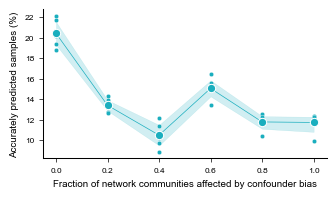

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager
font_dirs = ['/home/gonzag46/.fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42  # Output Type 42 (TrueType), editable in Illustrator


# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Ensure Method is treated as a numeric value
df['Method'] = df['Method'].astype(float)

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# # Define a color palette that matches the existing figures
# palette = {
#     0: 'grey',
#     0.1: '#E2FAFA',
#     0.2: '#B0F3F0',
#     0.3: '#7DDCE0',
#     0.4: '#4BC5CF',
#     0.5: '#1AAEBE',
#     0.6: '#1AAEBE',
#     0.7: '#1AAEBE',
#     0.8: '#1AAEBE',
#     0.9: '#1AAEBE',
#     1: '#1AAEBE'
# }





with sns.plotting_context(plotting_context):
    # Initialize the plot with two subplots
    fig, ax = plt.subplots(figsize=(3.543, 2.19), sharey=False)
    sns.lineplot(ax=ax, data=df, x='Method', y=metric, color='#1AAEBE', marker='o', markersize=6)
    sns.scatterplot(ax=ax, data=df, x='Method', y=metric, color='#1AAEBE', s=10, legend=False)
    # ax1.set_xlabel('PPI confidence quantile cutoff')
    ax.set_ylabel('Accurately predicted samples (%)')
    # ax.set_ylim(0, 1.3)


    ax.set_xlabel('Fraction of network communities affected by confounder bias')  # X-axis title for Genetic
    # ax2.set_xlabel('')  # X-axis title for Genetic

    # Adjust layout
    plt.subplots_adjust(bottom=0.2, right=0.95, left=0.15)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred_lineplot.pdf'))
    plt.show()


## Panel nDCG

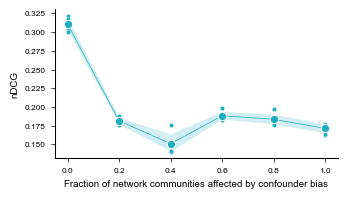

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the data for 'rankings' into a DataFrame
metric = 'nDCG'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Ensure Method is treated as a numeric value
df['Method'] = df['Method'].astype(float)

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# # Define a color palette that matches the existing figures
# palette = {
#     0: 'grey',
#     0.1: '#E2FAFA',
#     0.2: '#B0F3F0',
#     0.3: '#7DDCE0',
#     0.4: '#4BC5CF',
#     0.5: '#1AAEBE',
#     0.6: '#1AAEBE',
#     0.7: '#1AAEBE',
#     0.8: '#1AAEBE',
#     0.9: '#1AAEBE',
#     1: '#1AAEBE'
# }





with sns.plotting_context(plotting_context):
    # Initialize the plot with two subplots
    fig, ax = plt.subplots(figsize=(3.543, 2.19), sharey=False)
    sns.lineplot(ax=ax, data=df, x='Method', y=metric, color='#1AAEBE', marker='o', markersize=6)
    sns.scatterplot(ax=ax, data=df, x='Method', y=metric, color='#1AAEBE', s=10, legend=False)
    # ax1.set_xlabel('PPI confidence quantile cutoff')
    ax.set_ylabel('nDCG')
    # ax.set_ylim(0, 1.3)


    ax.set_xlabel('Fraction of network communities affected by confounder bias')  # X-axis title for Genetic
    # ax2.set_xlabel('')  # X-axis title for Genetic

    # Adjust layout
    plt.subplots_adjust(bottom=0.2, right=0.95, left=0.15)
    sns.despine()
    plt.savefig(osp.join(outdir, 'panel_ndcg_lineplot.pdf'))
    plt.show()
